<a href="https://colab.research.google.com/github/AndresRestrepoRodriguez/computer_vision/blob/main/Transferlearning_Pytorch_Computer_Vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install wget

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9675 sha256=217751971898a65ab487bb53a220c9af7422c728bc998f5e30fc424d2ab9313f
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget


In [2]:
import wget 

wget.download('https://mymldatasets.s3.eu-de.cloud-object-storage.appdomain.cloud/flowers.zip')

'flowers.zip'

In [3]:
import zipfile

with zipfile.ZipFile('flowers.zip', 'r') as zip_ref:
    zip_ref.extractall('.')

In [4]:
import os 

PATH = 'flowers'

classes = os.listdir(PATH)
classes

['tulip', 'rose', 'daisy', 'sunflower', 'dandelion']

In [5]:
imgs, labels = [], []

for i, lab in enumerate(classes):
  paths = os.listdir(f'{PATH}/{lab}')
  print(f'Categoría: {lab}. Imágenes: {len(paths)}')
  paths = [p for p in paths if p[-3:] == "jpg"]
  imgs += [f'{PATH}/{lab}/{img}' for img in paths]
  labels += [i]*len(paths)

Categoría: tulip. Imágenes: 984
Categoría: rose. Imágenes: 784
Categoría: daisy. Imágenes: 769
Categoría: sunflower. Imágenes: 734
Categoría: dandelion. Imágenes: 1055


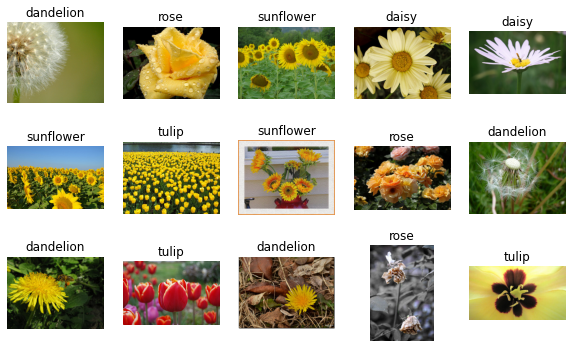

In [6]:
import random 
from skimage import io
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3,5, figsize=(10,6))
for _ax in axs:
  for ax in _ax:
    ix = random.randint(0, len(imgs)-1)
    img = io.imread(imgs[ix])
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(classes[labels[ix]])
plt.show()

In [7]:
from sklearn.model_selection import train_test_split

train_imgs, test_imgs, train_labels, test_labels = train_test_split(imgs, labels, test_size=0.2, stratify=labels)

len(train_imgs), len(test_imgs)

(3458, 865)

In [8]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"

In [9]:
class Dataset(torch.utils.data.Dataset):
  def __init__(self, X, y, transformation, device):
    self.X = X
    self.y = y
    self.transformation = transformation
    self.device = device
  
  def __len__(self):
    return len(self.X)

  def __getitem__(self, ix):
    img = io.imread(self.X[ix])
    if self.transformation:
      img = self.transformation(image=img)["image"]
    return torch.from_numpy(img/255.).float().permute(2,0,1), torch.tensor(self.y[ix])

In [30]:
import albumentations as album
trans = album.Compose([
                       album.Resize(224, 224),
                       album.HorizontalFlip(p=0.5),
                       album.ShiftScaleRotate(p=0.5)
                      ])
dataset = {
    'train': Dataset(train_imgs, train_labels, trans, device),
    'test': Dataset(test_imgs, test_labels, trans, device)
}

len(dataset['train']), len(dataset['test'])

(3458, 865)

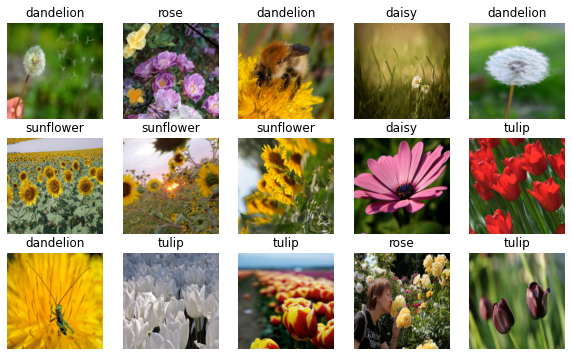

In [23]:
fig, axs = plt.subplots(nrows=3,ncols=5, figsize=(10,6))
for _ax in axs:
  for ax in _ax:
    ix = random.randint(0, len(dataset['train']))
    img, lab = dataset['train'][ix]
    ax.imshow(img.permute(1,2,0))
    ax.axis('off')
    ax.set_title(classes[lab])
plt.show()

In [24]:
dataloader = {
    'train': torch.utils.data.DataLoader(dataset['train'], batch_size=64, shuffle=True, pin_memory=True),
    'test': torch.utils.data.DataLoader(dataset['test'], batch_size=64, shuffle=False)
}
imgs, labels = next(iter(dataloader['train']))
imgs.shape

torch.Size([64, 3, 224, 224])

In [13]:
import torchvision

resnet = torchvision.models.resnet18()
resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [25]:
class Model(torch.nn.Module):
  def __init__(self, n_outputs=5, pretrained=False, freeze=False):
    super().__init__()
    resnet = torchvision.models.resnet18(pretrained=pretrained)
    self.resnet = torch.nn.Sequential(*list(resnet.children())[:-1])
    if freeze:
      for param in self.resnet.parameters():
        param.requires_grad=False
    self.fc = torch.nn.Linear(512, 5)

  def forward(self, x):
    x = self.resnet(x)
    x = x.view(x.shape[0], -1)
    x = self.fc(x)
    return x
  
  def unfreeze(self):
    for param in self.resnet.parameters():
      param.requires_grad = True


In [15]:
model = Model()
outputs = model(torch.randn(64, 3, 224, 224))
outputs.shape

torch.Size([64, 5])

In [47]:
from tqdm import tqdm
import numpy as np

def fit(model, dataloader, epochs=5, lr=1e-2):
  model.to(device)
  optimizer = torch.optim.SGD(model.parameters(), lr = lr)
  criterion = torch.nn.CrossEntropyLoss()
  for epoch in range(1, epochs+1):
    model.train()
    train_loss, train_acc = [], []
    bar = tqdm(dataloader['train'])
    for batch in bar:
      X, y = batch
      X, y = X.to(device), y.to(device)
      optimizer.zero_grad()
      y_hat = model(X)
      loss = criterion(y_hat, y)
      loss.backward()
      optimizer.step()
      train_loss.append(loss.item())
      acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
      train_acc.append(acc)
      bar.set_description(f"loss {np.mean(train_loss):.5f} acc {np.mean(train_acc):.5f}")
    bar = tqdm(dataloader['test'])
    val_loss, val_acc = [], []
    model.eval()
    with torch.no_grad():
      for batch in bar:
        X, y = batch
        X, y = X.to(device), y.to(device)
        y_hat = model(X)
        loss = criterion(y_hat, y)
        val_loss.append(loss.item())
        acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
        val_acc.append(acc)
        bar.set_description(f"val_loss {np.mean(val_loss):.5f} val_acc {np.mean(val_acc):.5f}")
    print(f"Epoch {epoch}/{epochs} loss {np.mean(train_loss):.5f} val_loss {np.mean(val_loss):.5f} acc {np.mean(train_acc):.5f} val_acc {np.mean(val_acc):.5f}")
  return train_acc, train_loss, val_acc, val_loss


In [48]:
model = Model(pretrained=True, freeze=True)
train_acc_freeze, train_loss_freeze, val_acc_freeze, val_loss_freeze = fit(model, dataloader)
model.unfreeze()
train_acc_unfreeze, train_loss_unfreeze, val_acc_unfreeze, val_loss_unfreeze = fit(model, dataloader, lr=1e-4, epochs=10)

val_loss 2.06156 val_acc 0.19937: 100%|██████████| 14/14 [00:03<00:00,  3.75it/s]


Epoch 1/5 loss 1.08360 val_loss 2.06156 acc 0.61761 val_acc 0.19937


val_loss 1.71283 val_acc 0.30415: 100%|██████████| 14/14 [00:03<00:00,  3.81it/s]


Epoch 2/5 loss 0.71763 val_loss 1.71283 acc 0.78466 val_acc 0.30415


val_loss 1.45875 val_acc 0.40314: 100%|██████████| 14/14 [00:03<00:00,  3.72it/s]


Epoch 3/5 loss 0.60696 val_loss 1.45875 acc 0.80568 val_acc 0.40314


val_loss 0.60947 val_acc 0.79420: 100%|██████████| 14/14 [00:03<00:00,  3.77it/s]


Epoch 4/5 loss 0.54534 val_loss 0.60947 acc 0.82017 val_acc 0.79420


val_loss 0.58444 val_acc 0.80070: 100%|██████████| 14/14 [00:03<00:00,  3.73it/s]


Epoch 5/5 loss 0.47385 val_loss 0.58444 acc 0.84688 val_acc 0.80070


val_loss 0.53273 val_acc 0.81179: 100%|██████████| 14/14 [00:03<00:00,  3.73it/s]


Epoch 1/10 loss 0.55101 val_loss 0.53273 acc 0.80057 val_acc 0.81179


val_loss 0.49225 val_acc 0.84088: 100%|██████████| 14/14 [00:04<00:00,  2.83it/s]


Epoch 2/10 loss 0.51408 val_loss 0.49225 acc 0.82102 val_acc 0.84088


val_loss 0.47699 val_acc 0.84639: 100%|██████████| 14/14 [00:04<00:00,  2.92it/s]


Epoch 3/10 loss 0.48611 val_loss 0.47699 acc 0.83722 val_acc 0.84639


val_loss 0.47197 val_acc 0.84862: 100%|██████████| 14/14 [00:05<00:00,  2.48it/s]


Epoch 4/10 loss 0.46459 val_loss 0.47197 acc 0.84432 val_acc 0.84862


val_loss 0.47721 val_acc 0.84987: 100%|██████████| 14/14 [00:03<00:00,  3.73it/s]


Epoch 5/10 loss 0.46562 val_loss 0.47721 acc 0.84233 val_acc 0.84987


val_loss 0.45704 val_acc 0.85427: 100%|██████████| 14/14 [00:03<00:00,  3.77it/s]


Epoch 6/10 loss 0.43358 val_loss 0.45704 acc 0.86278 val_acc 0.85427


val_loss 0.45450 val_acc 0.86851: 100%|██████████| 14/14 [00:03<00:00,  3.81it/s]


Epoch 7/10 loss 0.44964 val_loss 0.45450 acc 0.84290 val_acc 0.86851


val_loss 0.43905 val_acc 0.86536: 100%|██████████| 14/14 [00:03<00:00,  3.77it/s]


Epoch 8/10 loss 0.42363 val_loss 0.43905 acc 0.86392 val_acc 0.86536


val_loss 0.43578 val_acc 0.85525: 100%|██████████| 14/14 [00:05<00:00,  2.44it/s]


Epoch 9/10 loss 0.42085 val_loss 0.43578 acc 0.86619 val_acc 0.85525


val_loss 0.44242 val_acc 0.85971: 100%|██████████| 14/14 [00:04<00:00,  3.30it/s]

Epoch 10/10 loss 0.44290 val_loss 0.44242 acc 0.84830 val_acc 0.85971


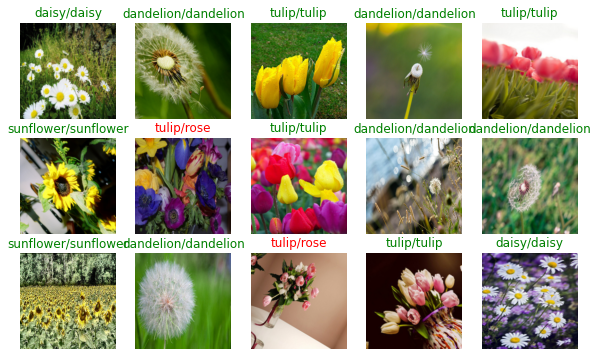

In [40]:
r, c = 3, 5
fig = plt.figure(figsize=(2*c, 2*r))
for _r in range(r):
    for _c in range(c):
      plt.subplot(r, c, _r*c + _c + 1)
      ix = random.randint(0, len(dataset['test'])-1)
      img, label = dataset['test'][ix]
      preds = model(img.unsqueeze(0).to(device))
      pred = torch.argmax(preds, axis=1)[0].item()
      plt.imshow(img.permute(1,2,0))
      plt.axis('off')
      plt.title(f'{classes[label]}/{classes[pred]}', color = "red" if label != pred else "green")
plt.show()